In [13]:
import itertools
import json
from pathlib import Path
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

In [14]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
bert_models = [None, "MRPC", "CoLA", "MNLI", "RTE", "SST", "WNLI", "SNLI", "QQP"]
checkpoint_steps = [1000, 2000, 3000, 4000, 5000]
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-5000"

In [24]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_metadata = {
    None: {
        "first_loss": None,
        "steps": {}
    }
}

for model in bert_models:
    if model not in model_metadata:
        model_metadata[model] = {"steps": {}}
    print(model)
        
    # brain decoding results for each checkpoint step
    for checkpoint_step in checkpoint_steps:
        decoding_perf_path = "perf.384sentences.bert.base%s.csv" % \
            ("" if model is None else ".%s-%s-%d" % (finetune_desc, model, checkpoint_step))
        decoding_perf = pd.read_csv(decoding_perf_path, index_col=[0, 1])
        model_metadata[model]["steps"][checkpoint_step] = {
            "decoding_mean": decoding_perf.loc["ridge"].mean().mean(),
            "decoding_std": decoding_perf.loc["ridge"].mean(axis=1).std()
        }
    
    # global model data -- read from checkpoint
    from tensorflow.python.pywrap_tensorflow import NewCheckpointReader
    if model is None:
        model_dir = bert_path / bert_base_model
    else:
        model_dir = bert_path / ("%s.%s.%s" % (finetune_desc, bert_base_model, model))
    ckpt = NewCheckpointReader(str(model_dir / "model.ckpt"))
    if model is not None:
        model_metadata[model]["global_steps"] = ckpt.get_tensor("global_step")
        
        # Also get the size of the output space -- for analyzing loss values across different tasks
        model_metadata[model]["output_dims"] = ckpt.get_tensor("output_bias").shape[0]
        
    # events data
    import tensorflow as tf
    try:
        events_file = next(model_dir.glob("events.*"))
    except StopIteration:
        # no events data -- skip
        pass
    else:
        total_global_norm = 0.
        first_loss, cur_loss = None, None
        tags = set()
        for e in tf.train.summary_iterator(str(events_file)):
            for v in e.summary.value:
                tags.add(v.tag)
                if v.tag == "grads/global_norm":
                    total_global_norm += v.simple_value
                elif v.tag == "loss_2":
                    if e.step == 1:
                        first_loss = v.simple_value
                    cur_loss = v.simple_value
                    
            if e.step in checkpoint_steps:
                model_metadata[model]["steps"][e.step].update({
                    "total_global_norms": total_global_norm,
                    "loss": cur_loss,
                    "loss_norm": cur_loss / model_metadata[model]["output_dims"]
                })
                
        model_metadata[model]["first_loss"] = first_loss
        model_metadata[model]["first_loss_norm"] = first_loss / model_metadata[model]["output_dims"]

None
MRPC
CoLA
MNLI
RTE
SST
WNLI
SNLI
QQP


In [25]:
model_metadata

{None: {'first_loss': None,
  'steps': {1000: {'decoding_mean': 96.22619047617849,
    'decoding_std': 35.02916088178172},
   2000: {'decoding_mean': 96.22619047617849,
    'decoding_std': 35.02916088178172},
   3000: {'decoding_mean': 96.22619047617849,
    'decoding_std': 35.02916088178172},
   4000: {'decoding_mean': 96.22619047617849,
    'decoding_std': 35.02916088178172},
   5000: {'decoding_mean': 96.22619047617849,
    'decoding_std': 35.02916088178172}}},
 'MRPC': {'first_loss': 1.0247445106506348,
  'first_loss_norm': 0.5123722553253174,
  'global_steps': 5000,
  'output_dims': 2,
  'steps': {1000: {'decoding_mean': 112.01455026452848,
    'decoding_std': 29.04183264750665,
    'loss': 0.0012313765473663807,
    'loss_norm': 0.0006156882736831903,
    'total_global_norms': 41.30751874670386},
   2000: {'decoding_mean': 128.04133597887153,
    'decoding_std': 24.779661013301148,
    'loss': 0.00010463259241078049,
    'loss_norm': 5.2316296205390245e-05,
    'total_global_norm

In [38]:
# Flatten model results into a single collection.
model_metadata_flat = []

for model, metadata in model_metadata.items():
    for step, step_data in metadata["steps"].items():
        model_metadata_flat.append((model, step, step_data["decoding_mean"], step_data["decoding_std"],
                                    metadata.get("first_loss", None), metadata.get("first_loss_norm", None),
                                    step_data.get("loss", None), step_data.get("loss_norm", None),
                                    step_data.get("total_global_norms", None)))
        
df = pd.DataFrame(model_metadata_flat, columns=("model", "step", "decoding_mean", "decoding_std", "first_loss", "first_loss_norm", "loss", "loss_norm", "total_global_norms"))

In [39]:
df["loss_delta"] = df["loss"] - df["first_loss"]
df["loss_norm_delta"] = df["loss_norm"] - df["first_loss_norm"]
df

,model,step,decoding_mean,decoding_std,first_loss,first_loss_norm,loss,loss_norm,total_global_norms,loss_delta,loss_norm_delta
0,None,1000,96.226190,35.029161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,2000,96.226190,35.029161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,3000,96.226190,35.029161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,4000,96.226190,35.029161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,5000,96.226190,35.029161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MRPC,1000,112.014550,29.041833,1.024745,0.512372,0.001231,0.000616,41.307519,-1.023513,-0.511757
6,MRPC,2000,128.041336,24.779661,1.024745,0.512372,0.000105,0.000052,93.428619,-1.024640,-0.512320
7,MRPC,3000,129.463294,23.983979,1.024745,0.512372,0.003684,0.001842,93.645866,-1.021060,-0.510530
8,MRPC,4000,131.196429,24.496943,1.024745,0.512372,0.000031,0.000016,93.662231,-1.024713,-0.512357
9,MRPC,5000,131.154431,24.252570,1.024745,0.512372,0.000021,0.000011,142.616803,-1.024723,-0.512362


Text(0.5, 1.0, 'Decoding performance vs. total number of fine-tuning steps')

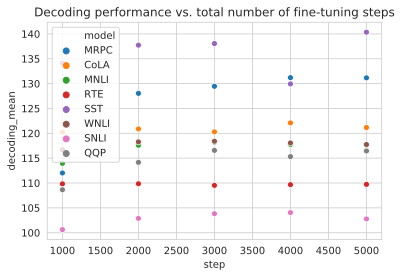

In [40]:
sns.scatterplot(data=df.reset_index(), y="decoding_mean", x="step", hue="model")
plt.title("Decoding performance vs. total number of fine-tuning steps")

Text(0.5, 1.0, 'Decoding performance vs. total global gradient norm')

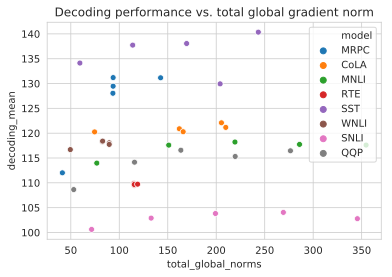

In [41]:
sns.scatterplot(data=df.reset_index(), y="decoding_mean", x="total_global_norms", hue="model")
plt.title("Decoding performance vs. total global gradient norm")

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Decoding performance vs. total global gradient norm')

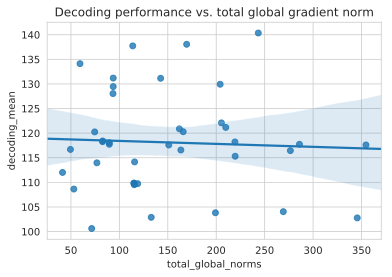

In [42]:
sns.regplot(data=df.reset_index(), y="decoding_mean", x="total_global_norms")
plt.title("Decoding performance vs. total global gradient norm")

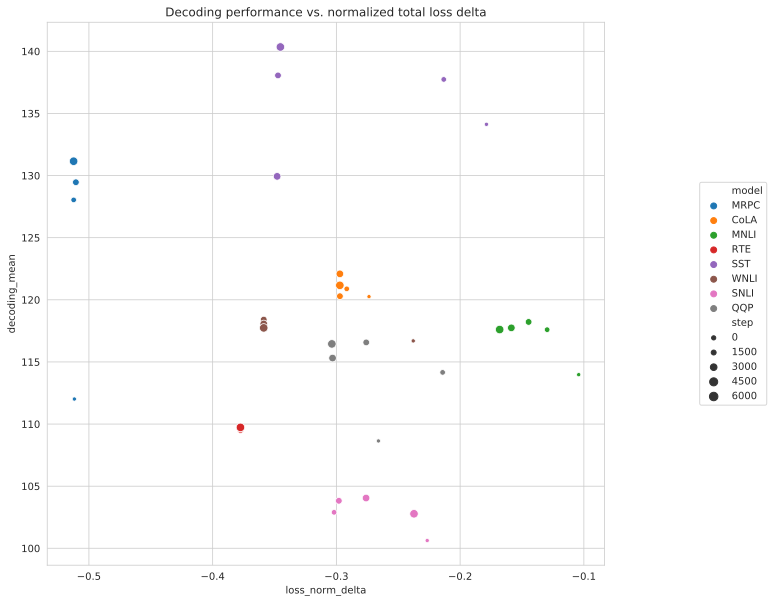

In [59]:
# NB: not directly comparable since the classification tasks have different output spaces
plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df.reset_index(), y="decoding_mean", x="loss_norm_delta", hue="model", size="step")
plt.title("Decoding performance vs. normalized total loss delta")
plt.legend(loc="right", bbox_to_anchor=(1.3, 0.5))

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 200)

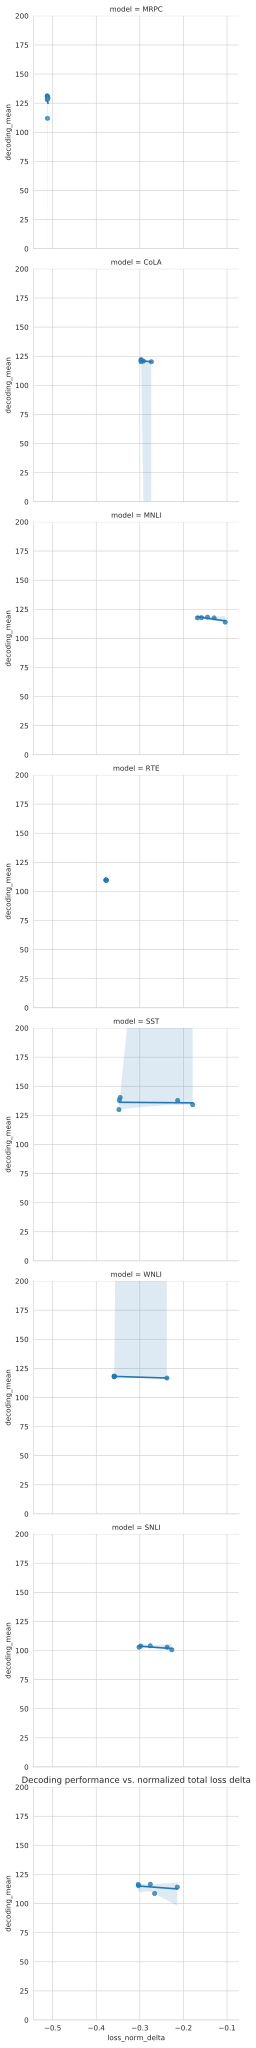

In [69]:
# NB: not directly comparable since the classification tasks have different output spaces
sns.lmplot(data=df.reset_index(), y="decoding_mean", x="loss_norm_delta", row="model", truncate=True)
plt.title("Decoding performance vs. normalized total loss delta")
plt.ylim((0, 200))

## Transfer checks

      m1    m2         0
0   CoLA  CoLA  0.828380
1   CoLA  MNLI  0.347631
2   CoLA  MRPC  0.683824
3   CoLA   QQP  0.638833
4   CoLA   RTE  0.545126
5   CoLA  SNLI  0.427759
6   CoLA   SST  0.527523
7   CoLA  WNLI  0.591549
8   MNLI  CoLA  0.691275
9   MNLI  MNLI  0.811615
10  MNLI  MRPC  0.683824
11  MNLI   QQP  0.633663
12  MNLI   RTE  0.505415
13  MNLI  SNLI  0.429283
14  MNLI   SST  0.544725
15  MNLI  WNLI  0.549296
16  MRPC  CoLA  0.691275
17  MRPC  MNLI  0.348956
18  MRPC  MRPC  0.838235
19  MRPC   QQP  0.633663
20  MRPC   RTE  0.465704
21  MRPC  SNLI  0.429689
22  MRPC   SST  0.527523
23  MRPC  WNLI  0.605634
24   QQP  CoLA  0.691275
25   QQP  MNLI  0.350178
26   QQP  MRPC  0.683824
27   QQP   QQP  0.873584
28   QQP   RTE  0.534296
29   QQP  SNLI  0.422882
..   ...   ...       ...
34   RTE  MRPC  0.683824
35   RTE   QQP  0.643532
36   RTE   RTE  0.703971
37   RTE  SNLI  0.430096
38   RTE   SST  0.522936
39   RTE  WNLI  0.549296
40  SNLI  CoLA  0.691275
41  SNLI  MNLI  0.349363


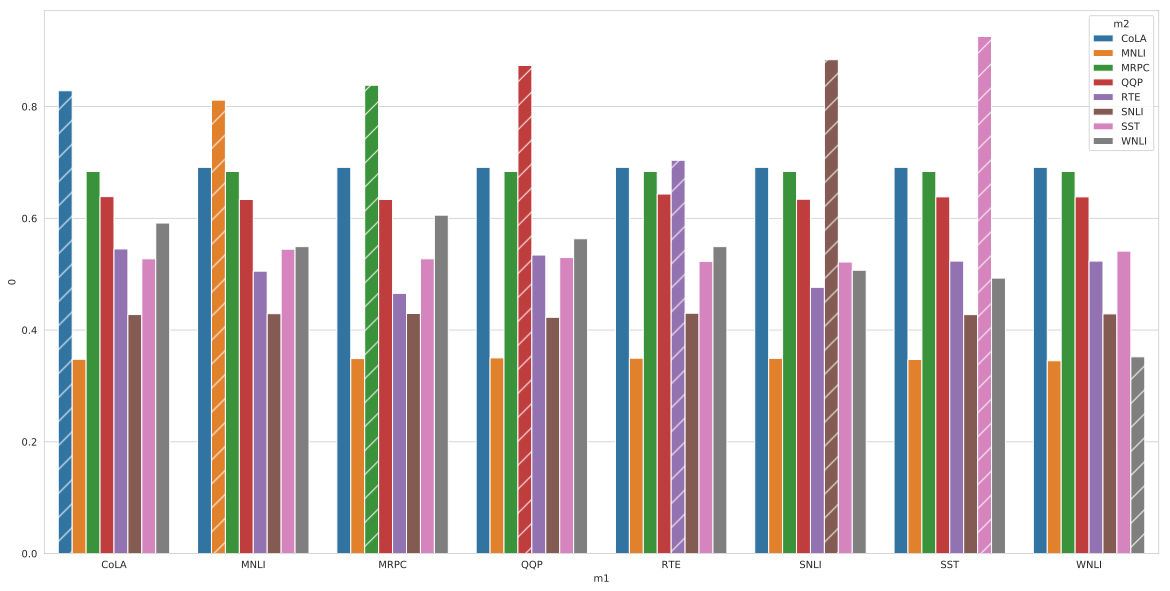

In [11]:
transfer_results = {}
for model in bert_models:
    # Get original fine-tune accuracy
    # TODO update "finetune" to `finetune_desc` once we have transfer data for the new limited finetune models
    results_path = bert_path / ("%s.%s.%s" % (finetune_desc, bert_base_model, model)) / "eval_results.txt"
    if results_path.exists():
        with results_path.open("r") as results_f:
            acc, = re.findall(r"^eval_accuracy\s*=\s*([\d.-]+)$", results_f.read(), re.M)
            acc = float(acc)
            transfer_results[model, model] = acc
            
for m1, m2 in itertools.product(bert_models, repeat=2):
    results_path = bert_path / ("eval_transfer-%s" % finetune_desc) / ("results-%s-%s.json" % (m1, m2))
    if not results_path.exists():
        continue
        
    with results_path.open("r") as results_f:
        transfer_results[m1, m2] = json.load(results_f)["results"]["eval_accuracy"]

plt.subplots(figsize=(20, 10))
transfer_results = pd.Series(transfer_results)
transfer_results.index.rename(["m1", "m2"], inplace=True)
transfer_results = transfer_results.sort_index().reset_index()
print(transfer_results)

ax = sns.barplot(data=transfer_results, hue="m2", x="m1", y=0)
i = 0
for bar in sorted(ax.patches, key=lambda bar: bar.get_x()):
    row = transfer_results.iloc[i]
    if not np.isnan(bar.get_height()):
        if row.m1 == row.m2:
            bar.set_hatch("/")
            
        i += 1

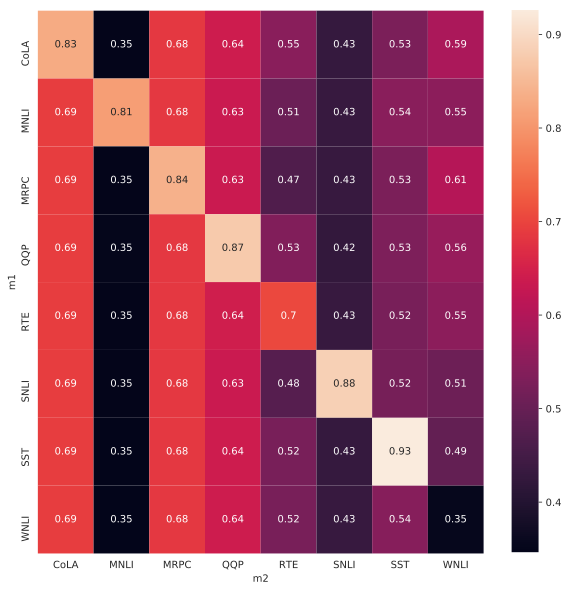

In [12]:
plt.subplots(figsize=(10,10))
sns.heatmap(data=pd.pivot_table(transfer_results, index="m1", columns="m2", values=0), annot=True)